In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Compute MSD slopes for each config ---
base_dir = '.'  # Adjust if your config folders are elsewhere.

# Get list of configuration folders (e.g., config_1, config_2, ..., config_64)
configs = [d for d in os.listdir(base_dir)
           if d.startswith('config_') and os.path.isdir(os.path.join(base_dir, d))]
configs.sort(key=lambda x: int(x.split('_')[1]))

def parse_rdf_file(filename):
    """
    Parse the rdf.out file into blocks.
    
    Each block starts with a header line: "TimeStep Number-of-rows"
    followed by that many data rows. Each data row should have 10 numbers:
      [index, radius, g(r1), c(1), g(r2), c(2), g(r3), c(3), g(r4), c(4)]
    
    Returns a dictionary mapping timestep (float) -> pandas DataFrame.
    """
    blocks = {}
    with open(filename, "r") as f:
        lines = f.readlines()
    
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if not line or line.startswith("#"):
            i += 1
            continue
        
        tokens = line.split()
        # Expect header lines with 2 tokens
        if len(tokens) == 2:
            timestep = float(tokens[0])
            nrows = int(tokens[1])
            i += 1  # move to data rows
            block_data = []
            for _ in range(nrows):
                if i >= len(lines):
                    break
                row_line = lines[i].strip()
                if row_line:
                    row_data = [float(tok) for tok in row_line.split()]
                    block_data.append(row_data)
                i += 1
            col_names = ["index", "radius", "g(r1)", "c(1)", 
                         "g(r2)", "c(2)", "g(r3)", "c(3)", 
                         "g(r4)", "c(4)"]
            df_block = pd.DataFrame(block_data, columns=col_names)
            blocks[timestep] = df_block
        else:
            i += 1
    return blocks


msd_data_dict = {}
msd_slopes = []
rdf_data_dict = {}

for config in configs:
    msd_file = os.path.join(base_dir, config, 'msd_adapt.out')
    if os.path.isfile(msd_file):
        try:
            # Read the MSD file, skipping comment lines
            data = pd.read_csv(msd_file, comment='#', sep='\s+', header=None)
            # Assign column names (adjust if your file structure is different)
            data.columns = ["TimeStep", "v_msd_all_val", "v_msd_1_val", "v_msd_8_val", "v_msd_9_val"]
            msd_data_dict[config] = data
            # Compute the slope using a simple linear fit (v_msd_all_val vs TimeStep)
            slope, _ = np.polyfit(data["TimeStep"], data["v_msd_all_val"], 1)
            msd_slopes.append((config, slope))
        except Exception as e:
            print(f"Error processing {msd_file}: {e}")
    # --- RDF data ---
    rdf_file = os.path.join(base_dir, config, 'rdf_adapt.out')
    if os.path.isfile(rdf_file):
        rdf_blocks = parse_rdf_file(rdf_file)
        if rdf_blocks:
            latest_ts = max(rdf_blocks.keys())
            rdf_data_dict[config] = rdf_blocks[latest_ts]
        else:
            print(f"No RDF blocks found in {rdf_file} for {config}")


<>:69: SyntaxWarning: invalid escape sequence '\s'
<>:69: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1740/2697583020.py:69: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(msd_file, comment='#', sep='\s+', header=None)


In [31]:
rdf_data_dict

{'config_1':     index    radius      g(r1)      c(1)      g(r2)      c(2)      g(r3)  \
 0     1.0  0.026843   0.000000  0.000000   0.000000  0.000000   0.000000   
 1     2.0  0.080529   0.000000  0.000000   0.000000  0.000000   0.000000   
 2     3.0  0.134215   0.000000  0.000000   0.000000  0.000000   0.000000   
 3     4.0  0.187901   0.000000  0.000000   0.000000  0.000000   0.000000   
 4     5.0  0.241587   0.000000  0.000000   0.000000  0.000000   0.000000   
 5     6.0  0.295273   0.000000  0.000000   0.000000  0.000000   0.000000   
 6     7.0  0.348959   0.000000  0.000000   0.000000  0.000000   0.000000   
 7     8.0  0.402645   0.000000  0.000000   0.000000  0.000000   0.000000   
 8     9.0  0.456331   0.000000  0.000000   0.000000  0.000000   0.000000   
 9    10.0  0.510017   0.000000  0.000000   0.000000  0.000000   0.000000   
 10   11.0  0.563703   0.000000  0.000000   0.000000  0.000000   0.000000   
 11   12.0  0.617389   0.000000  0.000000   0.000000  0.000000  

In [ ]:
import numpy as np
import pandas as pd

# Helper function to compute the height of the first RDF peak.
def get_first_rdf_peak_height(rdf_df, r_min=0.1, r_max=3.0):
    """
    Given an RDF DataFrame with columns "radius" and "g(r4)",
    returns the maximum of g(r4) within the interval [r_min, r_max].
    Adjust r_min and r_max to capture the first RDF peak.
    """
    subset = rdf_df[(rdf_df["radius"] >= r_min) & (rdf_df["radius"] <= r_max)]
    if subset.empty:
        return None
    return subset["g(r4)"].max()

# --- Create dictionaries to store the MSD slopes for each configuration ---
msd_full_dict = {}   # For the full data (msd)

for config in configs:
    if config in msd_data_dict:
        msd_df = msd_data_dict[config]
        
        # Compute the full MSD slope using all available data.
        try:
            slope_full, _ = np.polyfit(msd_df["TimeStep"], msd_df["v_msd_all_val"], 1)
        except Exception as e:
            print(f"Error computing full MSD slope for {config}: {e}")
            slope_full = None
        msd_full_dict[config] = slope_full

    else:
        msd_full_dict[config] = None

# Build the merged dataframe using the list of configuration names as the index.
merged_df = pd.DataFrame(index=configs)
merged_df["msd"] = pd.Series(msd_full_dict)

# --- Compute RDF first peak heights for each config ---
rdf_peak_dict = {}
for config in merged_df.index:
    if config in rdf_data_dict:
        rdf_df = rdf_data_dict[config]
        peak_val = get_first_rdf_peak_height(rdf_df)
        rdf_peak_dict[config] = peak_val
    else:
        rdf_peak_dict[config] = None

merged_df["rdf"] = pd.Series(rdf_peak_dict)

# Display the updated merged_df
print("Updated merged_df:")
print(merged_df)


Updated merged_df:
                msd      rdf
config_1   0.001994  11.6219
config_2   0.000853  15.1974
config_3   0.000020  38.0957
config_4   0.000058  28.1179
config_5   0.000569  18.5771
...             ...      ...
config_60  0.000088  28.2505
config_61  0.001200  12.9211
config_62  0.000029  30.9070
config_63  0.000454  19.5811
config_64  0.000027  32.4526

[64 rows x 2 columns]


In [12]:
merged_df.sort_values(by="msd", ascending=False, inplace=True)

In [13]:
merged_df

,msd,rdf
config_54,0.004738,7.3697
config_1,0.001994,11.6219
config_37,0.001512,11.0912
config_9,0.001248,14.6832
config_61,0.001200,12.9211
...,...,...
config_14,0.000019,36.5921
config_15,0.000015,33.2419
config_18,0.000015,34.6212
config_52,0.000014,39.0511


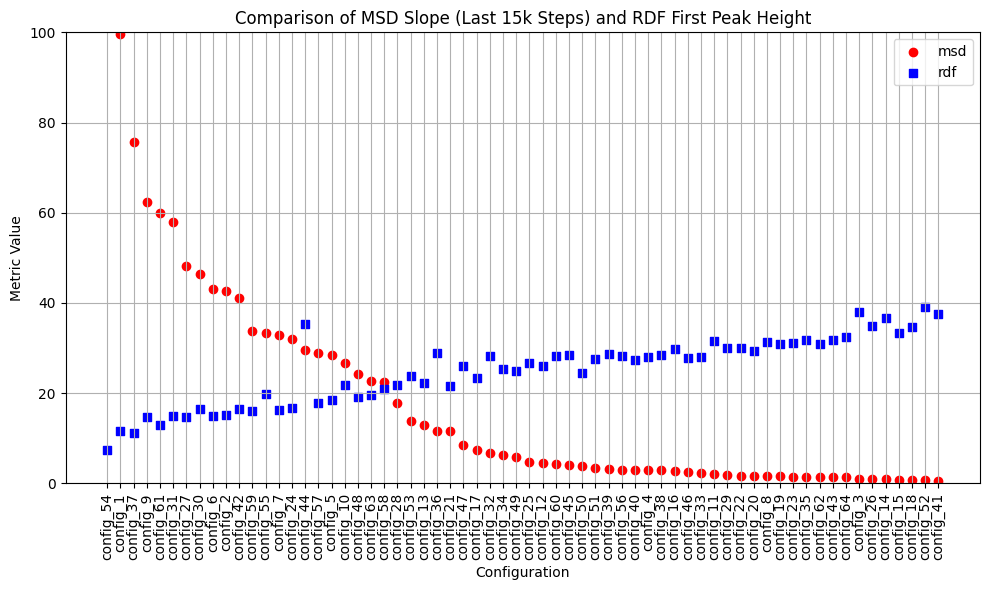

In [14]:
configs = merged_df.index.tolist()
x = np.arange(len(configs))

plt.figure(figsize=(10, 6))
# Plot the msd_slope_last15k (red circles)
plt.scatter(x, merged_df['msd']*50000, color='red', marker='o', label='msd')
# Plot the rdf_first_peak (blue squares)
plt.scatter(x, merged_df['rdf'], color='blue', marker='s', label='rdf')

# Annotate the x-axis with configuration names.
plt.xticks(x, configs, rotation=90)
plt.xlabel("Configuration")
plt.ylabel("Metric Value")
plt.title("Comparison of MSD Slope (Last 15k Steps) and RDF First Peak Height")
plt.legend()
plt.ylim(0,100)
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
merged_df[20:30]

,msd,rdf
config_63,0.000454,19.5811
config_58,0.000448,20.9086
config_28,0.000355,21.7491
config_53,0.000278,23.8745
config_13,0.000260,22.2365
config_36,0.000231,28.9399
config_21,0.000230,21.6784
config_47,0.000172,26.0779
config_17,0.000146,23.4611
config_32,0.000133,28.3212


In [16]:
# Convert index to a list
index_list = list(merged_df.index)

# Find positions of 'config_44' and 'config_47'
start = index_list.index('config_44')
end = index_list.index('config_47')

# Initialize status as 'unstable'
merged_df['status'] = 'unstable'

# Set 'stable' between start and end (inclusive)
merged_df.iloc[start:end+1, merged_df.columns.get_loc('status')] = 'stable'


In [18]:
import pandas as pd

# Show all rows
pd.set_option('display.max_rows', None)

# Show all columns (optional, if you have many)
pd.set_option('display.max_columns', None)

# Display the full DataFrame
merged_df


,msd,rdf,status
config_54,0.004738,7.3697,unstable
config_1,0.001994,11.6219,unstable
config_37,0.001512,11.0912,unstable
config_9,0.001248,14.6832,unstable
config_61,0.001200,12.9211,unstable
config_31,0.001161,14.8802,unstable
config_27,0.000966,14.6509,unstable
config_30,0.000930,16.4185,unstable
config_6,0.000860,14.9371,unstable
config_2,0.000853,15.1974,unstable


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MDAnalysis as mda
import networkx as nx
from scipy.spatial import cKDTree

# --- CONFIGURATION ---
CONFIG_ROOT = "."  # Parent folder containing config_* folders
DATA_FILE = "bilayer.data"
TRAJ_FILE = "full_traj.lammpstrj"
FRAME = -1           # Use the last frame of the trajectory
CUTOFF = 6.0        # Cutoff distance (adjust units as needed)

# --- GROUPING BEADS INTO LIPIDS ---
def group_lipids(u):
    """
    Build a graph from the bonds in the Universe.
    Each connected component of the graph is assumed to be one lipid.
    """
    G = nx.Graph()
    for atom in u.atoms:
        G.add_node(atom.index)
    if hasattr(u, 'bonds'):
        for bond in u.bonds:
            i = bond.atoms[0].index
            j = bond.atoms[1].index
            G.add_edge(i, j)
    else:
        raise RuntimeError("No bond information found in Universe. "
                           "Make sure your LAMMPS data file includes bonds.")
    # Each connected component represents a lipid
    lipid_components = list(nx.connected_components(G))
    # Optionally, filter components by size (here, require at least 3 atoms)
    lipid_components = [comp for comp in lipid_components if len(comp) >= 3]
    return lipid_components

def compute_com_for_lipid(u, indices):
    """
    Compute the center-of-mass for a lipid defined by a set of atom indices.
    Assumes equal mass for simplicity.
    """
    positions = np.array([u.atoms[i].position for i in indices])
    return positions.mean(axis=0)

# --- LOCAL TANGENT PLANE CONSTRUCTION ---
def local_tangent_basis(r):
    """
    Given a radial vector r from the sphere center, compute two perpendicular unit
    vectors (e1, e2) spanning the tangent plane at that point.
    """
    r_norm = np.linalg.norm(r)
    if r_norm < 1e-8:
        raise ValueError("Zero radial vector encountered!")
    r_unit = r / r_norm
    # Choose an arbitrary vector not parallel to r_unit
    arbitrary = np.array([1, 0, 0]) if abs(r_unit[0]) < 0.9 else np.array([0, 1, 0])
    # Remove the component along r_unit
    e1 = arbitrary - np.dot(arbitrary, r_unit) * r_unit
    e1 /= np.linalg.norm(e1)
    e2 = np.cross(r_unit, e1)
    return e1, e2

# --- HEXATIC ORDER CALCULATION USING LIPID COMs ---
def compute_hexatic_order_lipids(datafile, trajfile, cutoff=CUTOFF, frame=FRAME):
    """
    Load the LAMMPS data (and trajectory) and compute the hexatic order parameter
    for the lipid COMs. The procedure is:
      1. Group atoms into lipids using bond connectivity.
      2. Compute COM of each lipid.
      3. Estimate the global sphere center as the mean of COMs.
      4. For each lipid, define a local tangent plane (based on its radial vector)
         and compute angles to its neighbors (found via a KDTree).
      5. Calculate the local sixfold order parameter ψ₆ and average over lipids.
    """
    # Load Universe (using the LAMMPSDUMP format)
    u = mda.Universe(datafile, trajfile, format="LAMMPSDUMP")
    u.trajectory[frame]  # select the desired frame

    # Group beads into lipids using bond connectivity
    lipid_components = group_lipids(u)

    # Compute COM positions for each lipid
    lipid_COMs = []
    for comp in lipid_components:
        com = compute_com_for_lipid(u, comp)
        lipid_COMs.append(com)
    lipid_COMs = np.array(lipid_COMs)

    # Estimate the sphere center as the mean COM position
    center = lipid_COMs.mean(axis=0)

    # Build a KDTree for neighbor search among lipid COMs
    tree = cKDTree(lipid_COMs)
    n_lipids = len(lipid_COMs)

    psi6_values = []
    for i in range(n_lipids):
        pos_i = lipid_COMs[i]
        # Radial vector for lipid i
        r_vec = pos_i - center
        try:
            e1, e2 = local_tangent_basis(r_vec)
        except ValueError:
            continue  # skip if something goes wrong
        # Find the 7 nearest neighbors (including self)
        dists, indices = tree.query(pos_i, k=7)
        neighbor_angles = []
        for dist, j in zip(dists[1:], indices[1:]):  # skip self (first element)
            if dist > cutoff:
                continue
            pos_j = lipid_COMs[j]
            disp = pos_j - pos_i
            # Project disp onto the local tangent plane
            r_unit = r_vec / np.linalg.norm(r_vec)
            proj = disp - np.dot(disp, r_unit) * r_unit
            # Express in local basis (e1, e2)
            x_proj = np.dot(proj, e1)
            y_proj = np.dot(proj, e2)
            angle = np.arctan2(y_proj, x_proj)
            neighbor_angles.append(angle)
        if len(neighbor_angles) == 0:
            psi6_values.append(0.0)
        else:
            op_complex = np.mean(np.exp(1j * 6 * np.array(neighbor_angles)))
            psi6_values.append(np.abs(op_complex))
    if len(psi6_values) == 0:
        return np.nan
    return np.mean(psi6_values)

# --- BATCH ANALYSIS OVER CONFIG FOLDERS ---
def batch_hexatic(config_root):
    results = []
    # Loop over items in the config_root directory
    for item in sorted(os.listdir(config_root)):
        folder = os.path.join(config_root, item)
        # Only consider directories that contain both data and trajectory files
        data_path = os.path.join(folder, DATA_FILE)
        traj_path = os.path.join(folder, TRAJ_FILE)
        if not (os.path.isdir(folder) and os.path.isfile(data_path) and os.path.isfile(traj_path)):
            continue
        try:
            psi6_val = compute_hexatic_order_lipids(data_path, traj_path)
            results.append((item, psi6_val))
            print(f"Config {item}: psi6 = {psi6_val:.4f}")
        except Exception as e:
            print(f"[!] Failed on {item}: {e}")
            results.append((item, np.nan))
    return pd.DataFrame(results, columns=["config", "psi6"])

# --- MERGE WITH EXISTING merged_df ---
# Assume merged_df is already saved/loaded (e.g., via CSV)

# Run the batch hexatic analysis over all configs in CONFIG_ROOT
df_hexatic = batch_hexatic(CONFIG_ROOT)



/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/MDAnalysis/coordinates/LAMMPS.py:667: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt


Config config_1: psi6 = 0.3608
Config config_10: psi6 = 0.3989
Config config_11: psi6 = 0.5367
Config config_12: psi6 = 0.4918
Config config_13: psi6 = 0.4165
Config config_14: psi6 = 0.4054
Config config_15: psi6 = 0.4779
Config config_16: psi6 = 0.4581
Config config_17: psi6 = 0.5480
Config config_18: psi6 = 0.4432
Config config_19: psi6 = 0.5509
Config config_2: psi6 = 0.3785
Config config_20: psi6 = 0.5329
Config config_21: psi6 = 0.4266
Config config_22: psi6 = 0.4227
Config config_23: psi6 = 0.3958
Config config_24: psi6 = 0.4218
Config config_25: psi6 = 0.4786
Config config_26: psi6 = 0.3901
Config config_27: psi6 = 0.3642
Config config_28: psi6 = 0.4610
Config config_29: psi6 = 0.4937
Config config_3: psi6 = 0.5229
Config config_30: psi6 = 0.3756
Config config_31: psi6 = 0.3769
Config config_32: psi6 = 0.4857
Config config_33: psi6 = 0.5285
Config config_34: psi6 = 0.4667
Config config_35: psi6 = 0.4549
Config config_36: psi6 = 0.3635
Config config_37: psi6 = 0.3609
Config conf

KeyError: 'config'

Merged hexatic order (psi6) into merged_df and saved to 'merged_df_with_hexatic.csv'.


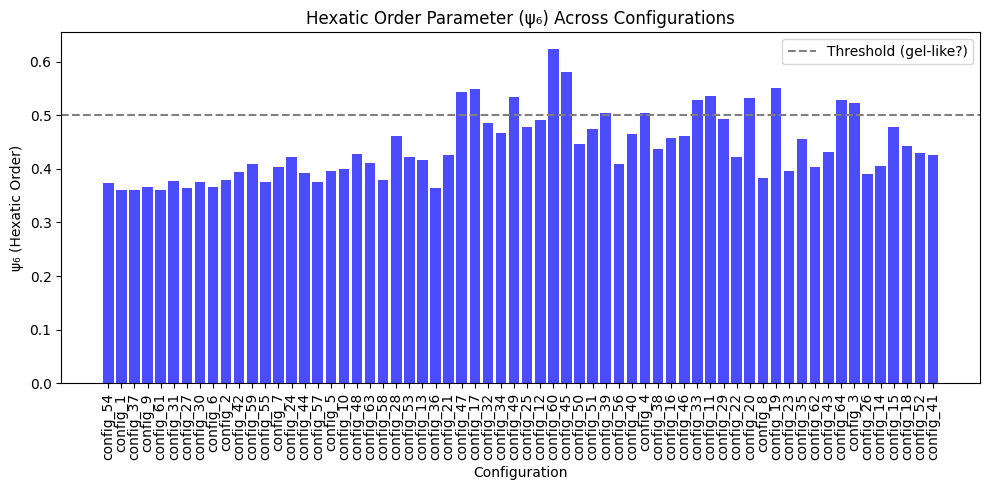

In [24]:
merged_df["config"] = merged_df.index

#Merge hexatic data into merged_df (based on config folder names)
merged_df = merged_df.merge(df_hexatic, on="config", how="left")
print("Merged hexatic order (psi6) into merged_df and saved to 'merged_df_with_hexatic.csv'.")

# --- OPTIONAL: Plot psi6 Only ---
configs = merged_df['config']
x = np.arange(len(merged_df))

plt.figure(figsize=(10, 5))
plt.bar(x, merged_df['psi6'], color='blue', alpha=0.7)
plt.xticks(x, configs, rotation=90)
plt.xlabel("Configuration")
plt.ylabel("ψ₆ (Hexatic Order)")
plt.title("Hexatic Order Parameter (ψ₆) Across Configurations")
plt.axhline(0.5, color='gray', linestyle='--', label='Threshold (gel-like?)')
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
columns = ['config', 'status', 'msd', 'rdf', 'psi6']
merged_df = merged_df[columns]
merged_df['rdf/msd'] = merged_df['rdf'] / merged_df['msd']
merged_df['psi/msd'] = merged_df['psi6'] / merged_df['msd']

/tmp/ipykernel_1740/3434696802.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['rdf/msd'] = merged_df['rdf'] / merged_df['msd']


In [30]:
merged_df

,config,status,msd,rdf,psi6,rdf/msd,psi/msd
0,config_54,unstable,0.004738,7.3697,0.372832,1.555422e+03,78.688573
1,config_1,unstable,0.001994,11.6219,0.360789,5.827349e+03,180.903776
2,config_37,unstable,0.001512,11.0912,0.360873,7.337469e+03,238.738483
3,config_9,unstable,0.001248,14.6832,0.366703,1.176743e+04,293.883255
4,config_61,unstable,0.001200,12.9211,0.361271,1.076707e+04,301.044779
5,config_31,unstable,0.001161,14.8802,0.376943,1.281925e+04,324.735432
6,config_27,unstable,0.000966,14.6509,0.364180,1.516745e+04,377.020018
7,config_30,unstable,0.000930,16.4185,0.375646,1.764868e+04,403.791550
8,config_6,unstable,0.000860,14.9371,0.365940,1.736493e+04,425.419226
9,config_2,unstable,0.000853,15.1974,0.378528,1.781850e+04,443.812206


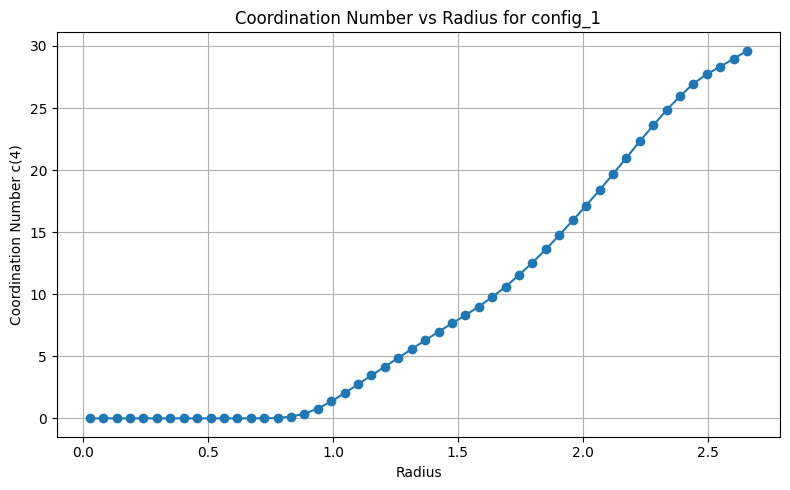

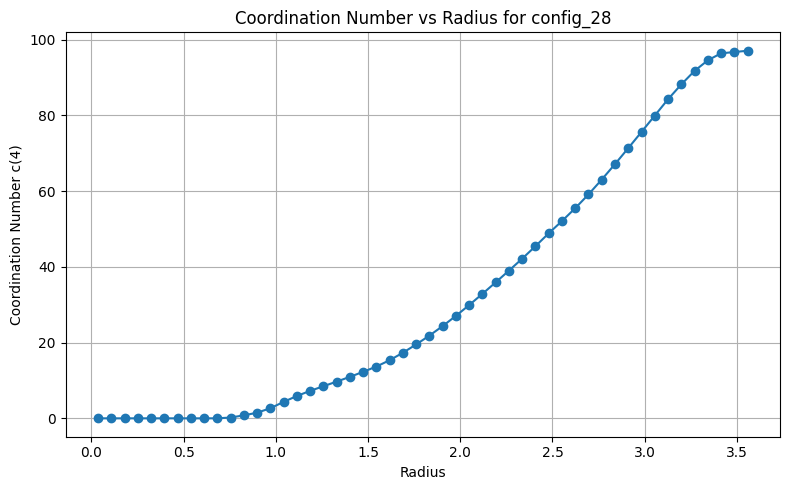

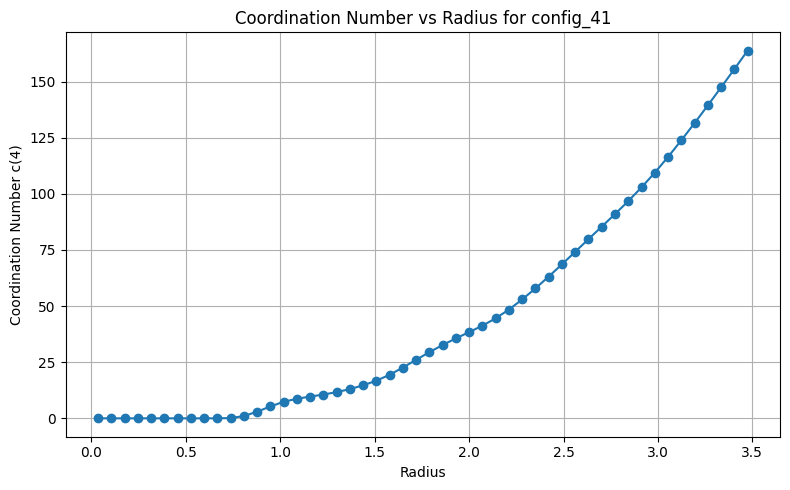

In [45]:
# Helper function to compute the height of the first RDF peak.
def get_coord(rdf_df, r_min=0.1, r_max=3.0, target_r=1.5):
    """
    Given an RDF DataFrame with columns "radius" and "g(r4)",
    returns the maximum of g(r4) within the interval [r_min, r_max].
    Adjust r_min and r_max to capture the first RDF peak.
    """
    subset = rdf_df[(rdf_df["radius"] >= r_min) & (rdf_df["radius"] <= r_max)]
    if subset.empty:
        return None, None
    # Find CN at r=1.5 (or closest available)
    r_array = subset["radius"].values
    cn_array = subset["c(4)"].values
    idx_closest = np.abs(r_array - target_r).argmin()
    cn_at_r = cn_array[idx_closest]

    # Compute overall slope (linear fit over the subset)
    slope = np.polyfit(r_array, cn_array, deg=1)[0]

    return cn_at_r, slope

# Initialize dictionaries to store both features
cn_at_1_5_dict = {}
slope_dict = {}

# Loop over each config
for config in merged_df['config']:
    if config in rdf_data_dict:
        rdf_df = rdf_data_dict[config]

        # Extract both features
        cn_at_1_5, overall_slope = get_coord(rdf_df)

        # Optional plotting for selected configs
        if config in ['config_1', 'config_28', 'config_41']:
            plt.figure(figsize=(8, 5))
            plt.plot(rdf_df["radius"], rdf_df["c(4)"], marker='o')
            plt.xlabel("Radius")
            plt.ylabel("Coordination Number c(4)")
            plt.title(f"Coordination Number vs Radius for {config}")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # Save results
        cn_at_1_5_dict[config] = cn_at_1_5
        slope_dict[config] = overall_slope

    else:
        cn_at_1_5_dict[config] = None
        slope_dict[config] = None

# Add both features to merged_df
merged_df["cn_at_1.5"] = merged_df["config"].map(cn_at_1_5_dict)
merged_df["cn_slope"] = merged_df["config"].map(slope_dict)


In [46]:
merged_df

,config,status,msd,rdf,psi6,rdf/msd,psi/msd,cn_at_1.5,cn_slope
0,config_54,unstable,0.004738,7.3697,0.372832,1.555422e+03,78.688573,5.24585,8.061779
1,config_1,unstable,0.001994,11.6219,0.360789,5.827349e+03,180.903776,7.65030,12.852165
2,config_37,unstable,0.001512,11.0912,0.360873,7.337469e+03,238.738483,7.47525,12.664334
3,config_9,unstable,0.001248,14.6832,0.366703,1.176743e+04,293.883255,9.74180,15.045733
4,config_61,unstable,0.001200,12.9211,0.361271,1.076707e+04,301.044779,8.47205,15.442065
5,config_31,unstable,0.001161,14.8802,0.376943,1.281925e+04,324.735432,8.73400,17.510090
6,config_27,unstable,0.000966,14.6509,0.364180,1.516745e+04,377.020018,8.63420,16.542858
7,config_30,unstable,0.000930,16.4185,0.375646,1.764868e+04,403.791550,9.01045,15.838495
8,config_6,unstable,0.000860,14.9371,0.365940,1.736493e+04,425.419226,9.71615,15.497401
9,config_2,unstable,0.000853,15.1974,0.378528,1.781850e+04,443.812206,9.21755,18.617183


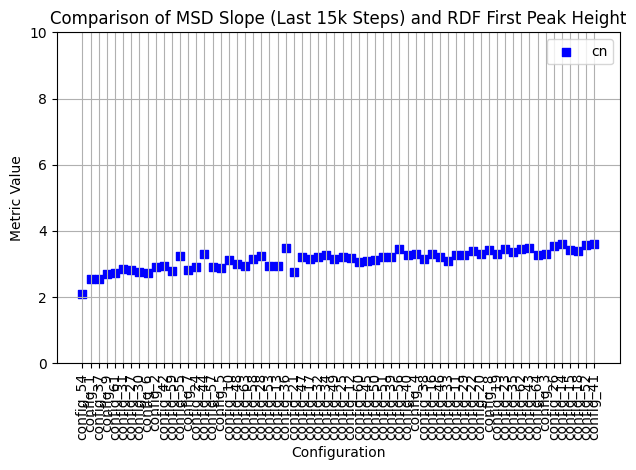

In [70]:
#plt.scatter(x, merged_df['msd']*100000, color='red', marker='o', label='msd')
# Plot the rdf_first_peak (blue squares)
plt.scatter(x, np.log(merged_df['cn_slope']), color='blue', marker='s', label='cn')

# Annotate the x-axis with configuration names.
plt.xticks(x, configs, rotation=90)
plt.xlabel("Configuration")
plt.ylabel("Metric Value")
plt.title("Comparison of MSD Slope (Last 15k Steps) and RDF First Peak Height")
plt.legend()
plt.ylim(0,10)
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
merged_df.columns

Index(['config', 'status', 'msd', 'rdf', 'psi6', 'rdf/msd', 'psi/msd',
       'cn_at_1.5', 'cn_slope'],
      dtype='object')

In [ ]:
merged_df["cn/msd"] = merged_df["cn_at_1.5"] / merged_df["msd"]
print(merged_df[["cn_at_1.5", "msd", "cn/msd"]].corr())


           cn_at_1.5       msd    cn/msd
cn_at_1.5   1.000000 -0.700802  0.709682
msd        -0.700802  1.000000 -0.386462
cn/msd      0.709682 -0.386462  1.000000


In [61]:
merged_df["cn_slope/msd"] = merged_df["cn_slope"] / merged_df["msd"]
print(merged_df[["cn_slope", "msd", "cn_slope/msd"]].corr())

              cn_slope       msd  cn_slope/msd
cn_slope      1.000000 -0.687752      0.752598
msd          -0.687752  1.000000     -0.378013
cn_slope/msd  0.752598 -0.378013      1.000000


In [65]:
merged_df.rename(columns={'cn/msd':'cn_1.5/msd'}, inplace=True)

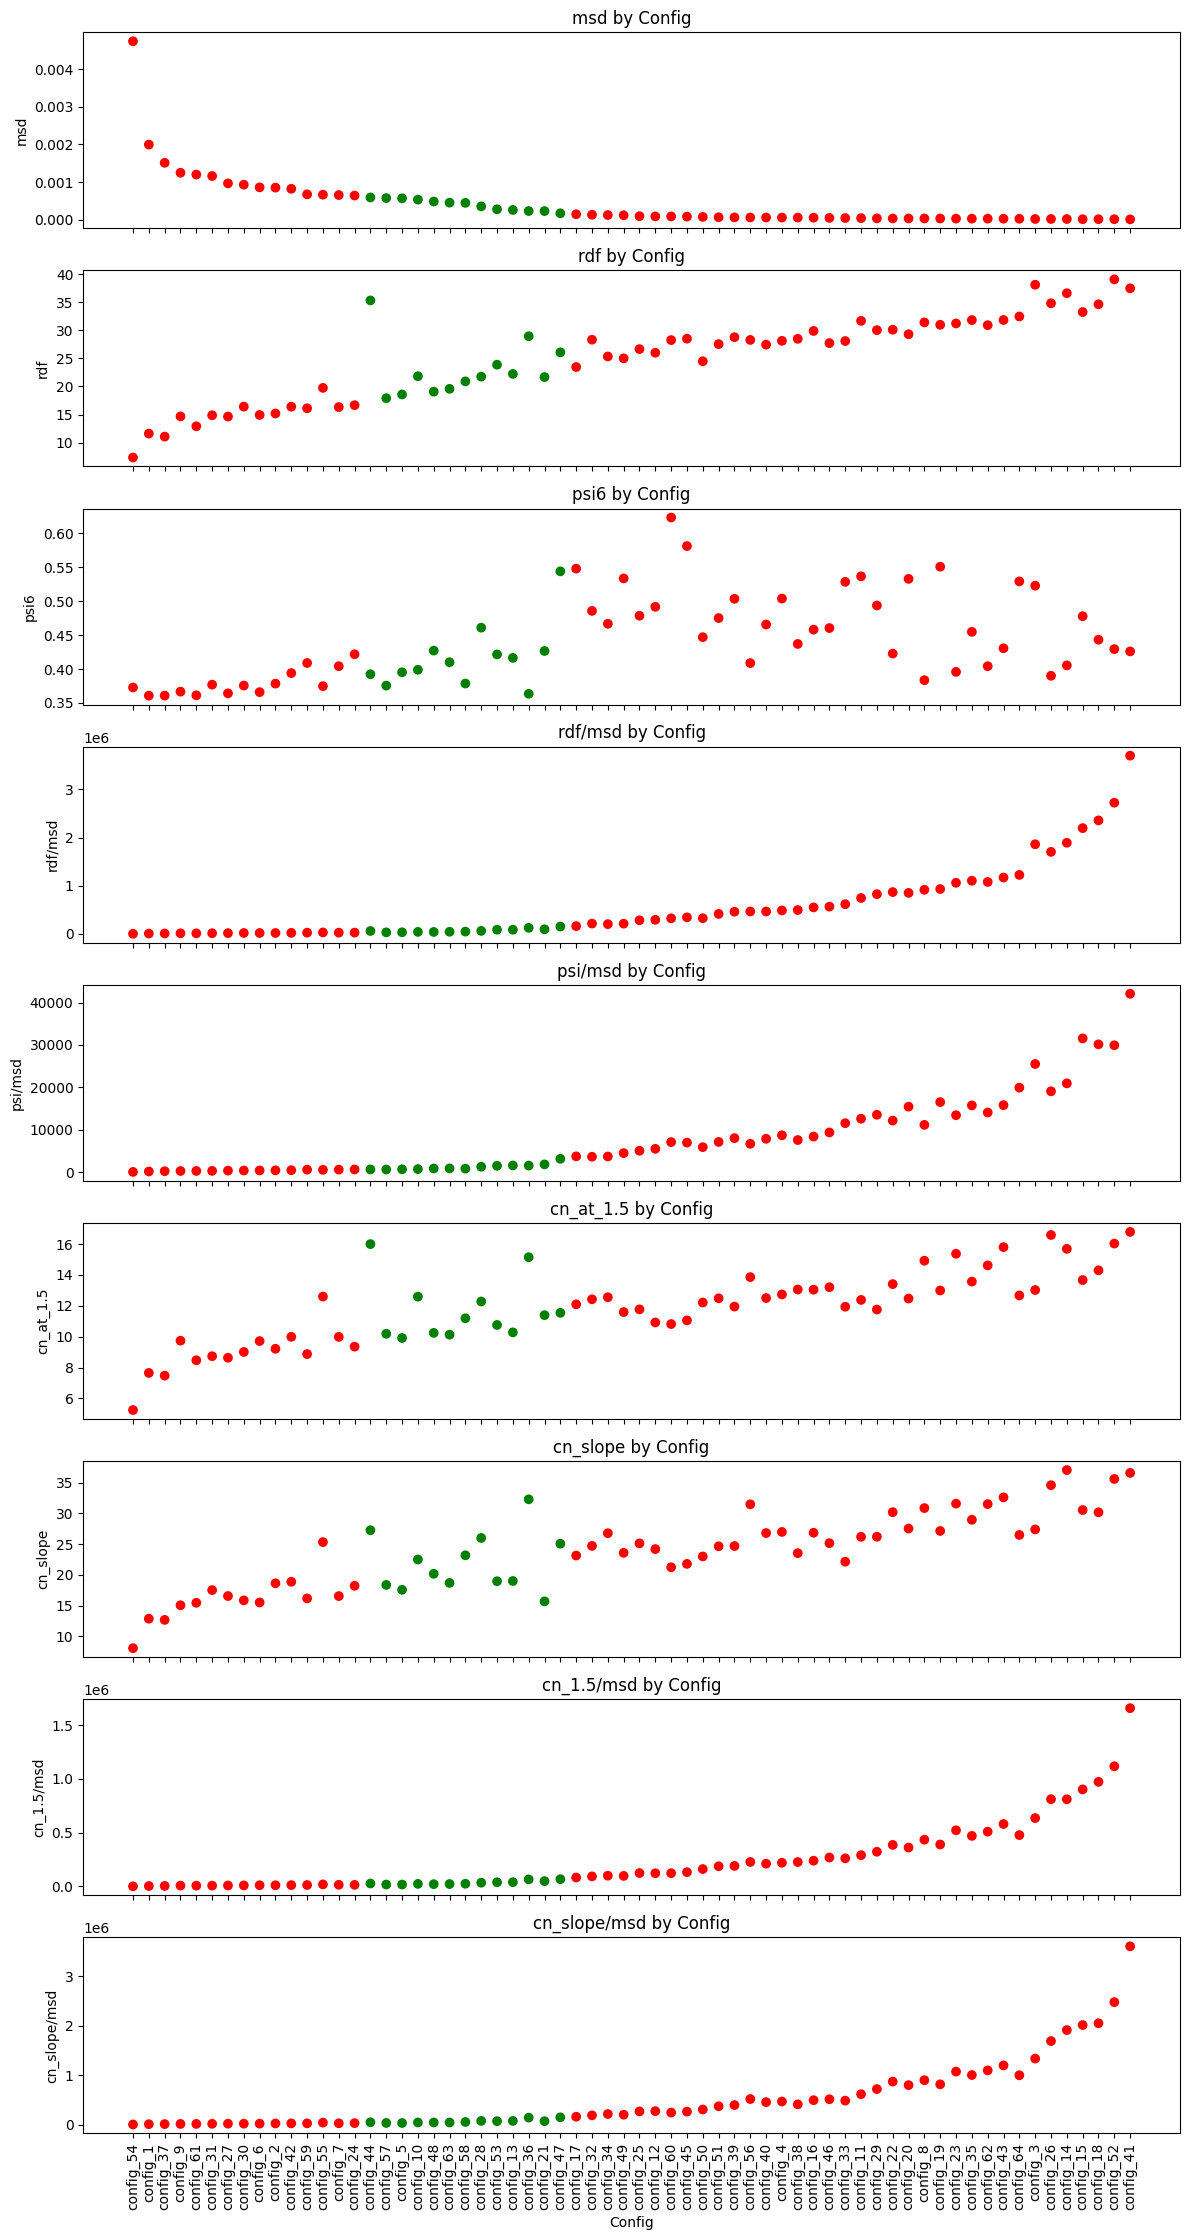

In [66]:
import matplotlib.pyplot as plt

# Define features to plot (excluding 'config' and 'status')
features_to_plot = [col for col in merged_df.columns if col not in ['config', 'status']]

# Map status to color
colors = merged_df["status"].map({'stable': 'green', 'unstable': 'red'})

# Create subplots
n_features = len(features_to_plot)
fig, axes = plt.subplots(n_features, 1, figsize=(12, 2.5 * n_features), sharex=True)

# Ensure axes is iterable
if n_features == 1:
    axes = [axes]

# Plot each feature
for ax, feature in zip(axes, features_to_plot):
    ax.scatter(merged_df['config'], merged_df[feature], c=colors)
    ax.set_ylabel(feature)
    ax.set_title(f"{feature} by Config")
    ax.tick_params(axis='x', labelrotation=90)

axes[-1].set_xlabel("Config")
plt.tight_layout()
plt.show()


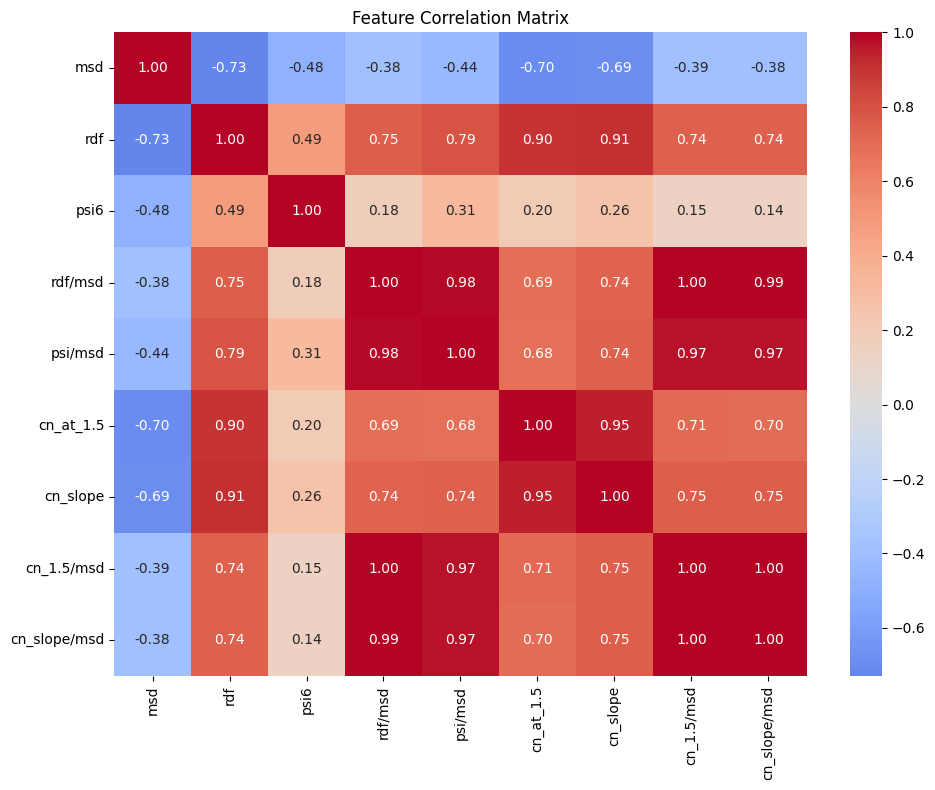

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure 'merged_df' is defined and includes your features
numeric_cols = [col for col in merged_df.columns if merged_df[col].dtype in ['float64', 'int64']]
corr_matrix = merged_df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()


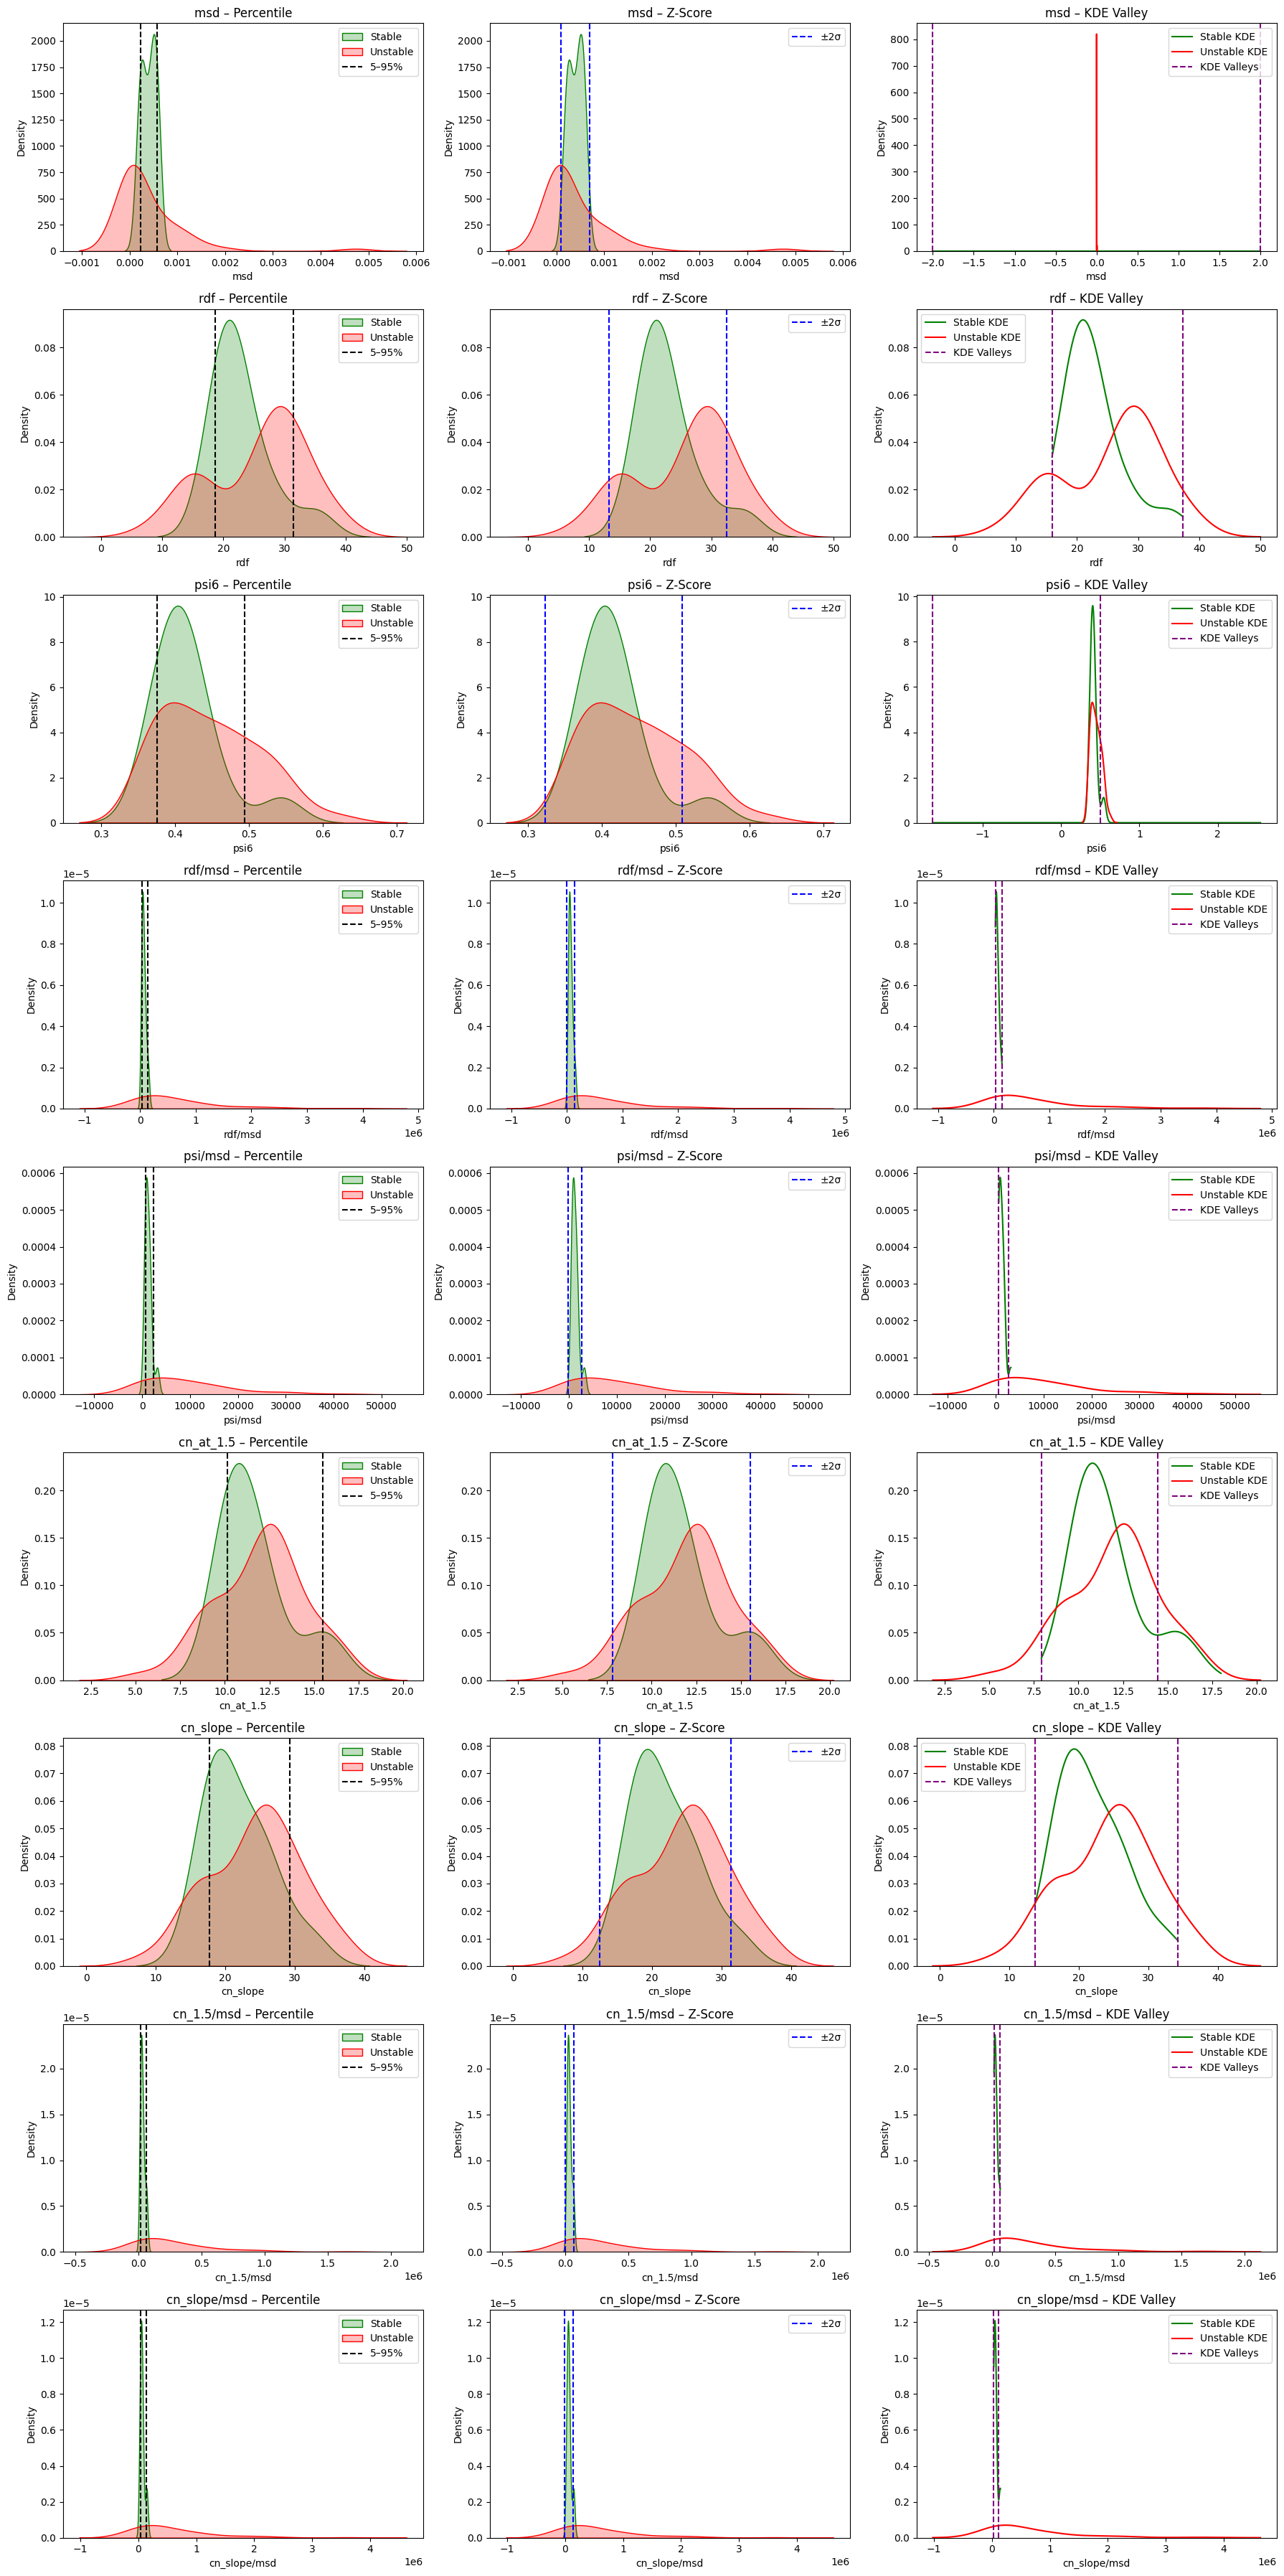

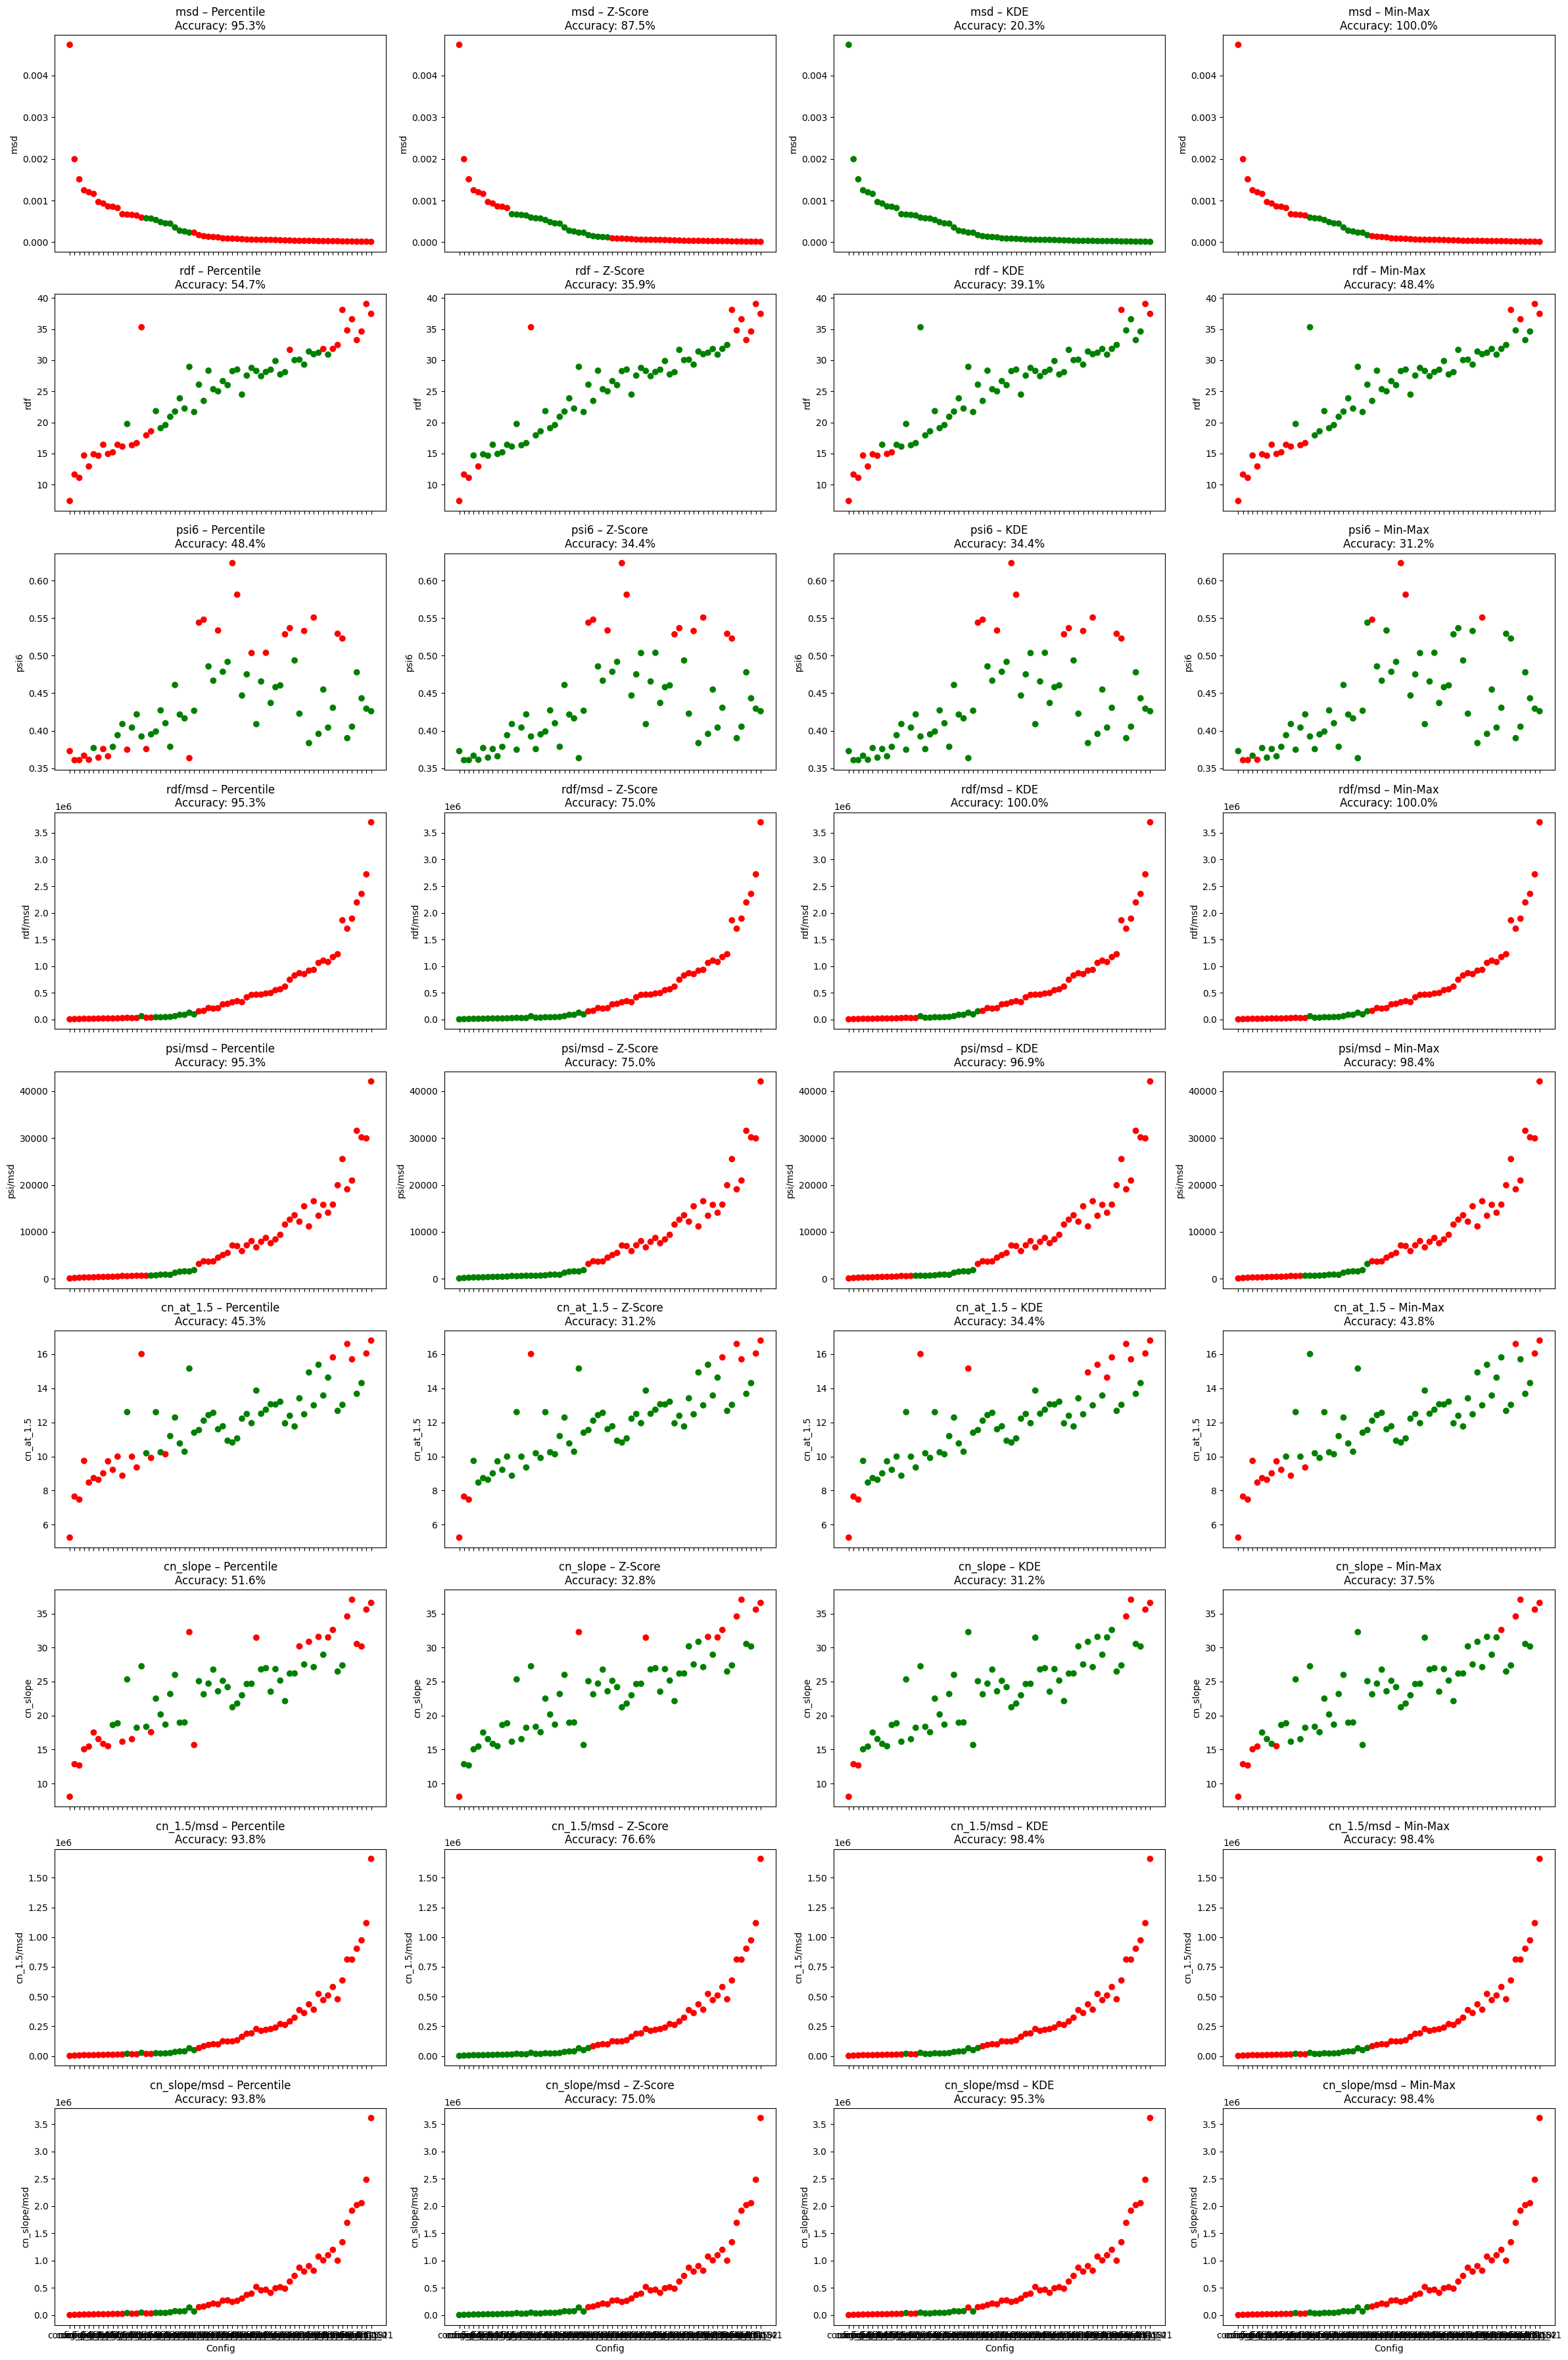


Classification Accuracy Report:
msd (Percentile): 61/64 correct (95.3%)
msd (Z-Score): 56/64 correct (87.5%)
msd (KDE): 13/64 correct (20.3%)
msd (Min-Max): 64/64 correct (100.0%)
rdf (Percentile): 35/64 correct (54.7%)
rdf (Z-Score): 23/64 correct (35.9%)
rdf (KDE): 25/64 correct (39.1%)
rdf (Min-Max): 31/64 correct (48.4%)
psi6 (Percentile): 31/64 correct (48.4%)
psi6 (Z-Score): 22/64 correct (34.4%)
psi6 (KDE): 22/64 correct (34.4%)
psi6 (Min-Max): 20/64 correct (31.2%)
rdf/msd (Percentile): 61/64 correct (95.3%)
rdf/msd (Z-Score): 48/64 correct (75.0%)
rdf/msd (KDE): 64/64 correct (100.0%)
rdf/msd (Min-Max): 64/64 correct (100.0%)
psi/msd (Percentile): 61/64 correct (95.3%)
psi/msd (Z-Score): 48/64 correct (75.0%)
psi/msd (KDE): 62/64 correct (96.9%)
psi/msd (Min-Max): 63/64 correct (98.4%)
cn_at_1.5 (Percentile): 29/64 correct (45.3%)
cn_at_1.5 (Z-Score): 20/64 correct (31.2%)
cn_at_1.5 (KDE): 22/64 correct (34.4%)
cn_at_1.5 (Min-Max): 28/64 correct (43.8%)
cn_slope (Percentile):

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema

# Helper functions
def get_kde_valley_thresholds(stable_vals):
    kde = gaussian_kde(stable_vals)
    x_grid = np.linspace(stable_vals.min() - 2, stable_vals.max() + 2, 1000)
    kde_vals = kde(x_grid)
    minima_indices = argrelextrema(kde_vals, np.less)[0]
    valleys = x_grid[minima_indices]
    peak_idx = np.argmax(kde_vals)
    left_valley = valleys[valleys < x_grid[peak_idx]].max() if any(valleys < x_grid[peak_idx]) else x_grid[0]
    right_valley = valleys[valleys > x_grid[peak_idx]].min() if any(valleys > x_grid[peak_idx]) else x_grid[-1]
    return left_valley, right_valley, x_grid, kde_vals

def get_percentile_bounds(stable_vals):
    return stable_vals.quantile(0.10), stable_vals.quantile(0.95)

def get_zscore_bounds(stable_vals):
    mu = stable_vals.mean()
    sigma = stable_vals.std()
    return mu - 2 * sigma, mu + 2 * sigma

# Setup
features = [col for col in merged_df.columns if col not in ['config', 'status']]
classification_df = merged_df.copy()

# Store classification accuracies
accuracy_report = []
accuracy_dict = {}  # for labeling plots

# First plot: KDEs and threshold boundaries
n = len(features)
fig1, axes1 = plt.subplots(n, 3, figsize=(18, 4 * n))

for i, feature in enumerate(features):
    stable_vals = classification_df[classification_df["status"] == "stable"][feature].dropna()
    unstable_vals = classification_df[classification_df["status"] == "unstable"][feature].dropna()

    # Thresholds
    p_low, p_high = get_percentile_bounds(stable_vals)
    z_low, z_high = get_zscore_bounds(stable_vals)
    k_low, k_high, x_grid, kde_vals = get_kde_valley_thresholds(stable_vals)
    min_stable = stable_vals.min()
    max_stable = stable_vals.max()

    # Store accuracy values to label on second plot
    accuracy_dict[feature] = {}

    # Plot 1: Percentile
    ax = axes1[i, 0]
    sns.kdeplot(stable_vals, fill=True, ax=ax, color='green', label="Stable")
    sns.kdeplot(unstable_vals, fill=True, ax=ax, color='red', label="Unstable")
    ax.axvline(p_low, color='black', linestyle='--', label='5–95%')
    ax.axvline(p_high, color='black', linestyle='--')
    ax.set_title(f"{feature} – Percentile")
    ax.legend()

    # Plot 2: Z-score
    ax = axes1[i, 1]
    sns.kdeplot(stable_vals, fill=True, ax=ax, color='green')
    sns.kdeplot(unstable_vals, fill=True, ax=ax, color='red')
    ax.axvline(z_low, color='blue', linestyle='--', label='±2σ')
    ax.axvline(z_high, color='blue', linestyle='--')
    ax.set_title(f"{feature} – Z-Score")
    ax.legend()

    # Plot 3: KDE
    ax = axes1[i, 2]
    ax.plot(x_grid, kde_vals, label="Stable KDE", color='green')
    sns.kdeplot(unstable_vals, ax=ax, color='red', label="Unstable KDE")
    ax.axvline(k_low, color='purple', linestyle='--', label='KDE Valleys')
    ax.axvline(k_high, color='purple', linestyle='--')
    ax.set_title(f"{feature} – KDE Valley")
    ax.legend()

    # Apply classifications and store accuracy
    x = classification_df[feature]
    for suffix, low, high in zip(["p", "z", "k", "minmax"],
                                 [p_low, z_low, k_low, min_stable],
                                 [p_high, z_high, k_high, max_stable]):
        colname = f"{feature}_{suffix}"
        classification_df[colname] = x.apply(lambda val: "stable" if low <= val <= high else "unstable")
        correct = (classification_df[colname] == classification_df["status"]).sum()
        total = len(classification_df)
        accuracy = correct / total
        accuracy_report.append({"feature": feature, "method": suffix, "correct": correct, "total": total, "accuracy": accuracy})
        accuracy_dict[feature][suffix] = f"{accuracy * 100:.1f}%"

plt.tight_layout()
plt.show()

# Second plot: Configs vs Feature Values colored by classification
fig2, axes2 = plt.subplots(n, 4, figsize=(24, 4 * n), sharex=True)

for i, feature in enumerate(features):
    x = classification_df["config"]
    y = classification_df[feature]

    for j, suffix in enumerate(["p", "z", "k", "minmax"]):
        method_col = f"{feature}_{suffix}"
        colors = classification_df[method_col].map({'stable': 'green', 'unstable': 'red'})
        axes2[i, j].scatter(x, y, c=colors)
        axes2[i, j].set_ylabel(feature)
        title = f"{feature} – {'Percentile' if suffix=='p' else 'Z-Score' if suffix=='z' else 'KDE' if suffix=='k' else 'Min-Max'}"
        acc_label = accuracy_dict[feature][suffix]
        axes2[i, j].set_title(f"{title}\nAccuracy: {acc_label}")

axes2[-1, 0].set_xlabel("Config")
axes2[-1, 1].set_xlabel("Config")
axes2[-1, 2].set_xlabel("Config")
axes2[-1, 3].set_xlabel("Config")
plt.tight_layout()
plt.show()

# Print summary stats
print("\nClassification Accuracy Report:")
for row in accuracy_report:
    method_name = {'p': 'Percentile', 'z': 'Z-Score', 'k': 'KDE', 'minmax': 'Min-Max'}[row['method']]
    print(f"{row['feature']} ({method_name}): {row['correct']}/{row['total']} correct ({row['accuracy']:.1%})")


In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema

# Helper functions
def get_kde_valley_thresholds(stable_vals):
    kde = gaussian_kde(stable_vals)
    x_grid = np.linspace(stable_vals.min() - 2, stable_vals.max() + 2, 1000)
    kde_vals = kde(x_grid)
    minima_indices = argrelextrema(kde_vals, np.less)[0]
    valleys = x_grid[minima_indices]
    peak_idx = np.argmax(kde_vals)
    left_valley = valleys[valleys < x_grid[peak_idx]].max() if any(valleys < x_grid[peak_idx]) else x_grid[0]
    right_valley = valleys[valleys > x_grid[peak_idx]].min() if any(valleys > x_grid[peak_idx]) else x_grid[-1]
    return left_valley, right_valley, x_grid, kde_vals

def get_zscore_bounds(stable_vals):
    mu = stable_vals.mean()
    sigma = stable_vals.std()
    return mu - 2 * sigma, mu + 2 * sigma

# Setup
features = [col for col in merged_df.columns if col not in ['config', 'status']]
classification_df = merged_df.copy()

# Store optimal percentile thresholds and accuracies
optimal_thresholds = {}

# Scan percentiles from 1% to 10%
percentiles = np.arange(0.01, 0.11, 0.01)

for feature in features:
    stable_vals = classification_df[classification_df["status"] == "stable"][feature].dropna()
    full_vals = classification_df[feature].dropna()
    true_labels = classification_df.loc[full_vals.index, "status"]

    best_acc = 0
    best_range = None

    for p in percentiles:
        low = stable_vals.quantile(p)
        high = stable_vals.quantile(1 - p)

        predicted = full_vals.apply(lambda x: "stable" if low <= x <= high else "unstable")
        acc = (predicted == true_labels).mean()

        if acc > best_acc:
            best_acc = acc
            best_range = (p, low, high)

    optimal_thresholds[feature] = {
        "percentile": best_range[0],
        "low": best_range[1],
        "high": best_range[2],
        "accuracy": best_acc
    }

# Print summary
print("\nOptimal Percentile Thresholds:")
for feature, info in optimal_thresholds.items():
    print(f"{feature}: {100*info['percentile']:.0f}th–{100*(1-info['percentile']):.0f}th | "
          f"Low={info['low']:.4f}, High={info['high']:.4f} | Accuracy={info['accuracy']:.1%}")


Optimal Percentile Thresholds:
msd: 1th–99th | Low=0.0002, High=0.0006 | Accuracy=96.9%
rdf: 10th–90th | Low=18.6781, High=28.3675 | Accuracy=70.3%
psi6: 10th–90th | Low=0.3762, High=0.4542 | Accuracy=64.1%
rdf/msd: 1th–99th | Low=31300.6681, High=148685.8875 | Accuracy=96.9%
psi/msd: 4th–96th | Low=657.0129, High=2536.8451 | Accuracy=96.9%
cn_at_1.5: 7th–93th | Low=10.0970, High=15.2875 | Accuracy=48.4%
cn_slope: 10th–90th | Low=17.7141, High=26.9989 | Accuracy=56.2%
cn_1.5/msd: 1th–99th | Low=17448.8746, High=67055.6087 | Accuracy=95.3%
cn_slope/msd: 1th–99th | Low=30959.5559, High=145178.2680 | Accuracy=95.3%


In [89]:
merged_df.to_csv("merged_df.csv", index=False)